In [1]:
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [6]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
batch_size = 32

In [9]:
train_generator = train_datagen.flow_from_directory(
        '../data/train_folder',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 10254 images belonging to 12 classes.


In [10]:
validation_generator = test_datagen.flow_from_directory(
        '../data/validation_folder',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 1140 images belonging to 12 classes.


In [11]:
train_generator2 = train_datagen.flow_from_directory(
        '../data/train_folder',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode="rgb",
        seed=42,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 10254 images belonging to 12 classes.


In [12]:
validation_generator2 = test_datagen.flow_from_directory(
        '../data/validation_folder',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        class_mode='categorical')

Found 1140 images belonging to 12 classes.


In [13]:
test_generator2 = test_datagen.flow_from_directory(
    directory='../data/holdout_folder',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    seed=42)

Found 1266 images belonging to 12 classes.


In [14]:
evaluate_generator = test_datagen.flow_from_directory(
        '../data/validation_folder',
        target_size=(224, 224),
        batch_size=1,
        seed=42,
        class_mode='categorical')

Found 1140 images belonging to 12 classes.


In [15]:
from tensorflow.keras import backend as K
img_width, img_height = 224, 224
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [16]:
#prepared_images = preprocess_input(X_train)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense

In [18]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape = (224,224,3),pooling=max)


In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
#base_model.trainable = False

In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
inpt = Input(shape=(224,224,3),name = 'image_input')

In [24]:
output = base_model(inpt)

In [25]:
flat1 = Flatten(name='flatten')(output)
class1 = Dense(1024, activation='relu', name='fc1')(flat1)
output = Dense(12, activation='softmax', name='predictions')(class1)
# define new model
vgg_model = Model(inputs=inpt, outputs=output)

In [26]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              25691136  
_________________________________________________________________
predictions (Dense)          (None, 12)                12300     
Total params: 40,418,124
Trainable params: 32,782,860
Non-trainable params: 7,635,264
_________________________________________________________________


In [27]:
sgd = SGD(lr=0.001,momentum=0.9)

In [28]:
vgg_model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
steps_per_epoch = 100
epoch  = 100
def my_gen(gen):
    i=0
    while i < steps_per_epoch * epoch:
        try:
            data, labels = next(gen)
            i+=1
            yield data, labels
        except:
            pass

In [30]:
filepath="../checkpoints/vgg_v3_partial_unfreeze_weights_improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [31]:
from tensorflow.keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.002, mode= 'min', patience=10),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0,
    min_delta=0.01, cooldown=1, min_lr=0, mode = 'min'),
    callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
]

In [32]:
hist= vgg_model.fit(
        my_gen(train_generator2),
        steps_per_epoch=steps_per_epoch,
        epochs=epoch,
        validation_data=validation_generator2,
        callbacks=my_callbacks)

Epoch 1/100
100/100 [==============================] - 91s 910ms/step - loss: 2.0868 - accuracy: 0.2694 - val_loss: 1.3816 - val_accuracy: 0.4553 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 90s 901ms/step - loss: 1.4272 - accuracy: 0.4709 - val_loss: 1.1477 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 90s 902ms/step - loss: 1.2212 - accuracy: 0.5328 - val_loss: 1.1400 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 89s 892ms/step - loss: 1.1347 - accuracy: 0.5647 - val_loss: 0.8915 - val_accuracy: 0.6632 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 90s 899ms/step - loss: 1.0419 - accuracy: 0.6047 - val_loss: 0.8646 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 89s 895ms/step - loss: 0.9674 - accuracy: 0.6359 - val_loss: 0.8004 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 7/100
100/100 [=========================

In [33]:
vgg_model.save('../models/vgg_v3_partial_unfreeze.h5')

In [34]:
#vgg_history = vgg_model.fit(X_train, y_train, epochs=10,steps_per_epoch=50,validation_data=(X_val,y_val))

In [35]:
# test_loss, test_acc = vgg_model.evaluate(X_test, y_test, verbose=0)

# print('\nTest accuracy {:5.2f}%'.format(100*test_acc))

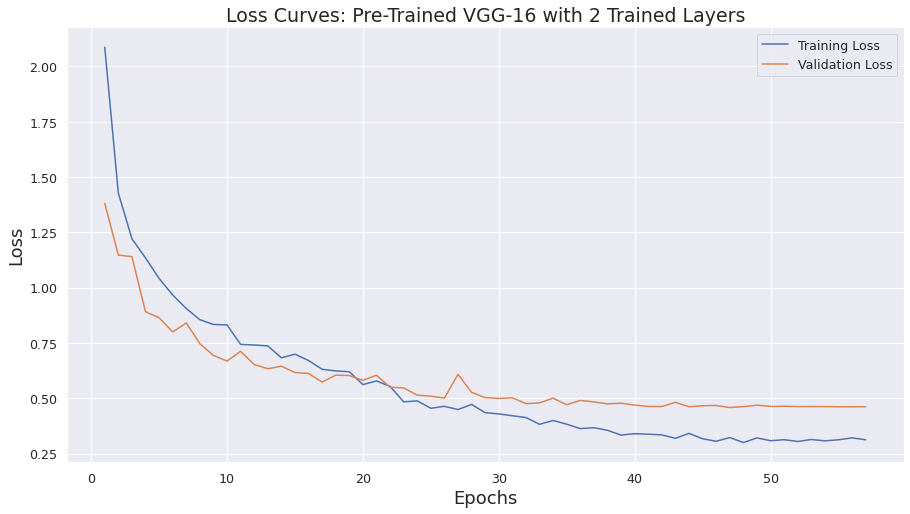

<Figure size 432x288 with 0 Axes>

In [43]:
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

epoch_count = range(1,len(training_loss)+1)
fig,ax = plt.subplots(figsize=(15,8))

sns.set(font_scale=1.15)
sns.lineplot(x=epoch_count,y=training_loss,ax=ax)
sns.lineplot(x=epoch_count,y=test_loss,ax=ax)

ax.set_title('Loss Curves: Pre-Trained VGG-16 with 2 Trained Layers',fontsize=19)
ax.set_ylabel('Loss',fontsize=18)
ax.set_xlabel('Epochs',fontsize=18)

plt.legend(['Training Loss', 'Validation Loss'])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss Curves')
plt.show();
plt.savefig('../data/graphs/vgg_partial_unfreeze_loss.png')

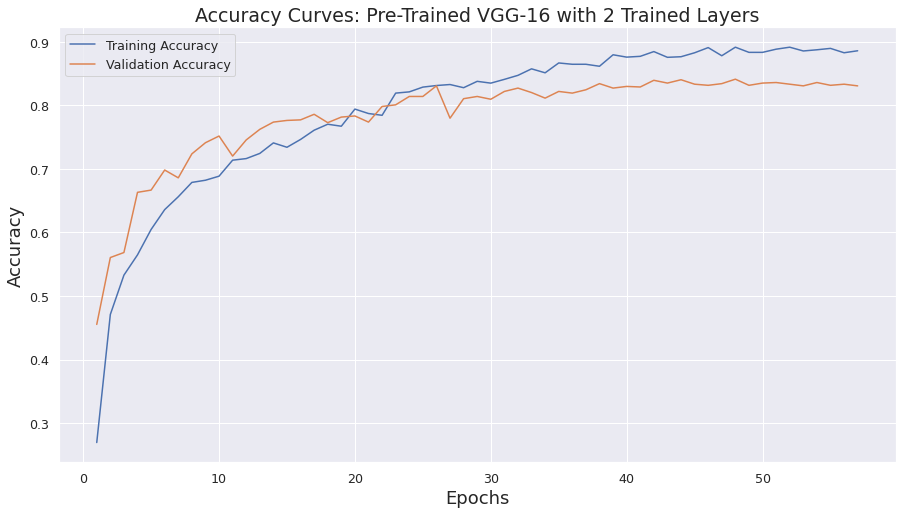

<Figure size 432x288 with 0 Axes>

In [42]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epoch_count = range(1,len(training_loss)+1)

fig,ax = plt.subplots(figsize=(15,8))
sns.set(font_scale=1.15)
sns.lineplot(x=epoch_count,y=acc,ax=ax)
sns.lineplot(x=epoch_count,y=val_acc,ax=ax)

ax.set_title('Accuracy Curves: Pre-Trained VGG-16 with 2 Trained Layers',fontsize=19)
ax.set_ylabel('Accuracy',fontsize=18)
ax.set_xlabel('Epochs',fontsize=18)

plt.legend(['Training Accuracy', 'Validation Accuracy'])

# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracies')
#plt.xlabel('Epoch')
plt.show();
plt.savefig('../data/graphs/vgg_partial_unfreeze_accuracy.png')

## Evaluation

In [52]:
del evaluate_generator

evaluate_generator= test_datagen.flow_from_directory(
        '../data/validation_folder',
        target_size=(224, 224),
        batch_size=1,
        seed=42,
        class_mode='categorical')

Found 1140 images belonging to 12 classes.


In [53]:
STEP_SIZE_EVALUATE=evaluate_generator.n//evaluate_generator.batch_size

vgg_model.evaluate_generator(generator=evaluate_generator,steps=STEP_SIZE_EVALUATE)

[0.4623292088508606, 0.8307017683982849]

In [ ]:
test_generator2